In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Load text helpers
import text_helpers

C:\Users\snuist\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

## 파라미터 세팅

In [3]:
sess = tf.Session()

batch_size = 200            # Model Batch Size
embedding_size = 50        # word embedding size
vocabulary_size = 2000      # Maximum vocabulary size
generations = 50000         # number of iterations for training.
model_learning_rate = 0.05   # Learning rate

num_sampled = int(batch_size/2) # Number of negative examples to sample.
window_size = 3                 # How many words to consider left and right.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 1000

## Data 로딩 및 전처리

In [4]:
# Declare stopwords
stops = stopwords.words('english')

# test words. We are expecting synonyms to appear
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
# Later we will have to transform these into indices

# Load the movie review data
print("Loading Data")
texts, target = text_helpers.load_movie_data()  # target: 0(negative)/1(positive)

# Normalize text
print("Normalizing Text Data")
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split())>2] 
texts = [x for x in texts if len(x.split())>2] # 너무 짧은 글은 제외
print("Done.")

Loading Data
Normalizing Text Data
Done.


## Word Dictionary

In [5]:
print("Creating Dictionary")
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]

Creating Dictionary


## CBOW model

In [6]:
print("Creating Model")
# Define embeddings
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# NCE Loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                             stddev=1.0/np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[batch_size,2*window_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Lookup the word embedding
# Add together window embeddings:
embed = tf.zeros([batch_size, embedding_size])
for element in range(2*window_size):  # 문맥이 되는 단어들의 합을 사용하여 중심단어 추정
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

Creating Model


In [7]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))

# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate).minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

## 모델 저장하기

In [8]:
# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings})

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

문맥의 길이를 2*window_size + 1로 정했기 때문에 이것보다 짧은 문장은 training에 있어 의미가 없다. 따라서 문장 길이가 7보다 긴 것들만 필터링해준다.

In [9]:
text_data = [x for x in text_data if len(x) >= (2*window_size+1)]

## 트레이닝

In [10]:
print("Starting Training")
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                 window_size, method='cbow')
    feed_dict = {x_inputs: batch_inputs, y_target: batch_labels}
    
    # Run the train step
    sess.run(optimizer, feed_dict=feed_dict)
    
    # Return the loss
    if (i+1)% print_loss_every==0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
        
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5
            nearest = (-sim[j,:]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every ==0:
        with open(os.path.join(data_folder_name, 'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name, 'cbow_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 1000 : 9.67491626739502
Loss at step 2000 : 6.243814468383789
Loss at step 3000 : 5.550598621368408
Loss at step 4000 : 5.641958236694336
Loss at step 5000 : 4.849673748016357
Nearest to love: exercise, anything, situations, striking, charismatic,
Nearest to hate: career, relatively, head, brought, trek,
Nearest to happy: choose, birthday, morality, told, needs,
Nearest to sad: ask, fashion, gets, many, disappointing,
Nearest to man: watching, wonderful, ludicrous, fascinating, obvious,
Nearest to woman: form, j, amateurish, imagination, tribute,
Model saved in file: C:\Users\snuist\Dlearning\NLP\Tensorflow cookbook\temp\cbow_movie_embeddings.ckpt
Loss at step 6000 : 5.111420631408691
Loss at step 7000 : 5.047321319580078
Loss at step 8000 : 4.750290393829346
Loss at step 9000 : 4.610687732696533
Loss at step 10000 : 4.788057327270508
Nearest to love: exercise, anything, situations, charismatic, striking,
Nearest to hate: career, relatively, head, brought

## Plotting

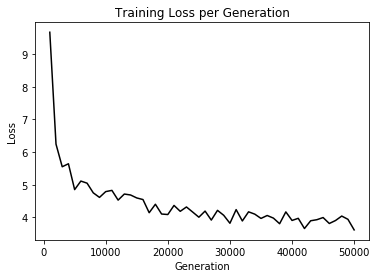

In [11]:
plt.plot(loss_x_vec, loss_vec, 'k-')
plt.title('Training Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

## 질문!
왜 similarity에 마이너스를 붙여서 하는지 모르겠다